In [1]:
!pip install -q biopython

     |████████████████████████████████| 2.3MB 5.3MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '/content/drive/My Drive/data/ChIP-seq/'
LOG_DIR = '/content/drive/My Drive/dna-nn/onehot-recurrent/'

Mounted at /content/drive


In [3]:
!cp -r '/content/drive/My Drive/dna_nn' .
!ls dna_nn

download.py  load.py


In [4]:
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.data import Dataset

from dna_nn.load import encode, encoded_shape, gen_from_fasta

%load_ext autoreload
%autoreload 2

In [5]:
# generators
word_size = 3
region_size = 2
subset_size = 690 * 190

x_shape = encoded_shape(range(101), word_size, region_size, expand=False)
encode_func = encode(word_size, region_size, expand=False)

train_file = DATA_DIR + 'motif_discovery_train.fasta'
test_file = DATA_DIR + 'motif_discovery_test.fasta'
train_gen = gen_from_fasta(train_file, encode_func)
test_gen = gen_from_fasta(test_file, encode_func)

# datasets
bacth_size = 512
prefetch = tf.data.experimental.AUTOTUNE

output_shapes = (x_shape, ())
output_types = (tf.float32, tf.float32)

train_ds = Dataset.from_generator(train_gen, output_types, output_shapes)
# takes about 30 seconds to skip the training data
val_ds = train_ds.skip(subset_size).take(690 * 10)
train_ds = train_ds.take(subset_size).shuffle(500).batch(bacth_size).prefetch(prefetch)

test_ds = Dataset.from_generator(test_gen, output_types, output_shapes)
test_ds = test_ds.take(subset_size).batch(bacth_size).prefetch(prefetch)

print('x shape:', train_ds.element_spec[0].shape)
print('y shape:', train_ds.element_spec[1].shape)

x shape: (None, 99, 192)
y shape: (None,)


In [6]:
for d in train_ds.take(1):
    print(d[0].shape)

(512, 99, 192)


In [7]:
%%time
x_val, y_val = [], []
for d in val_ds:
    x_val.append(d[0])
    y_val.append(d[1])
x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val)
validation_data = (x_val, y_val)

CPU times: user 1min 3s, sys: 3.89 s, total: 1min 7s
Wall time: 57.2 s


In [8]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Input(shape=x_shape),
    keras.layers.Dropout(0.5),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(128),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()
auc = keras.metrics.AUC()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', auc])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 99, 192)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 99, 64)            65792     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 181,249
Trainable params: 181,249
Non-trainable params: 0
__________________________________________________

In [9]:
version = 'v1-base'

callbacks = [
    keras.callbacks.CSVLogger(LOG_DIR + f'{version}.csv'),
    keras.callbacks.TensorBoard(log_dir=LOG_DIR + f'log/{version}/'),
    keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: gc.collect(),
        on_train_end=lambda logs: model.save(LOG_DIR + f'{version}.h5')
    ),
]
history = model.fit(train_ds, epochs=30, validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/30
      1/Unknown - 0s 54us/step - loss: 0.6923 - accuracy: 0.5195 - auc: 0.5308WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
      2/Unknown - 0s 106ms/step - loss: 0.6936 - accuracy: 0.4980 - auc: 0.4965WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0561s vs `on_train_batch_end` time: 0.1560s). Check your callbacks.
257/257 [==============================] - 66s 255ms/step - loss: 0.6591 - accuracy: 0.6043 - auc: 0.6471 - val_loss: 0.6242 - val_accuracy: 0.6530 - val_auc: 0.7090
Epoch 2/30
257/257 [==============================] - 65s 251ms/step - loss: 0.6397 - accuracy: 0.6368 - auc: 0.6850 - val_loss: 0.6433 - val_accuracy: 0.6439 - val_auc: 0.7386
Epoch 3/30
257/257 [================

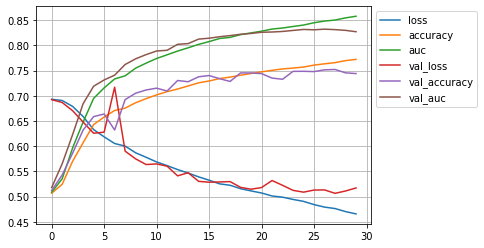

In [ ]:
ax = pd.DataFrame(history.history).plot()
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.grid()

In [ ]:
model.evaluate(test_ds)

257/257 [==============================] - 23s 91ms/step - loss: 0.5212 - accuracy: 0.7443 - auc: 0.8235


[0.5211902260780334, 0.744340181350708, 0.8234620690345764]